In [33]:
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
from matplotlib.colors import LogNorm
estilo_graficos = ["science", "nature"]
cm = 1/2.54
texto_pt = 8
proporciones = (6*cm, 5*cm)
dpi = 200 #@param

plt.style.use(estilo_graficos)
font_size_dict = {"axes.labelsize": texto_pt, "xtick.labelsize": texto_pt, "ytick.labelsize": texto_pt, "legend.fontsize": texto_pt, "font.size": texto_pt}
plt.rcParams.update(font_size_dict)
plt.rcParams['figure.figsize'] = proporciones
plt.rcParams['figure.dpi'] = dpi

In [34]:
# PARÁMETROS

H = 1               # [m] Distancia entre la camara y el patrón
n_aire = 1          # Índice de refracción del aire
n_agua = 1.33       # Índice de refracción del agua
n_vidrio = 1.5      # Índice de refracción del vidrio
hp = 2e-2*n_agua/n_aire + 2e-3*n_agua/n_vidrio  # [m] Grosor efectivo del fluído con desviaciones nulas
alpha = 1 - n_aire/n_agua

radio_corte = 2.5e-3 # Radio de la gota sobre el patrón
angulo_corte = np.pi/6

square_size = 1e-3    # Tamaño de los cuadrados del patrón _checkerboard_

In [35]:
# COORDENADAS
resolucion = 1e-2/500
x = np.arange(-1e-2, 1e-2, resolucion)  # [m]
y = np.arange(-0.01, 0.01, resolucion)  # [m]
X, Y = np.meshgrid(x, y)    # [m]
R = np.sqrt(X**2 + Y**2)    # [m]
er = np.array([X/R, Y/R])  # dirección radial

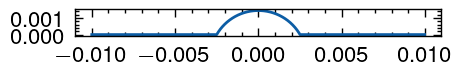

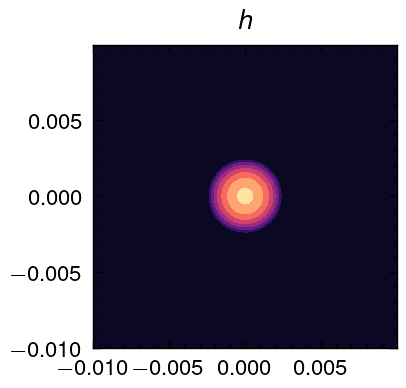

In [36]:
# MAPA DE ALTURAS
def height_map(x, y, radio_corte=radio_corte, angulo_corte=angulo_corte): 
    # hemisferio
    a = radio_corte/np.cos(angulo_corte)
    r = np.sqrt(x**2 + y**2)
    z = np.sqrt((a**2 - r**2)*(r<a))-a*np.sin(angulo_corte)
    return z*(z>0)

plt.plot(x, height_map(x, 0))
plt.gca().set_aspect("equal")
plt.show()

plt.title(r"$h$")
plt.contourf(X, Y, height_map(X, Y), cmap="magma")
plt.gca().set_aspect("equal");

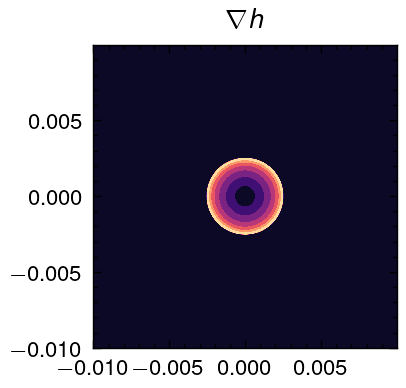

In [37]:
# GRADIENTE
def compute_gradient(f, X, Y, ds=1): # mi solución temporal a lo que está haciendo np.gradient
    return np.array([f(X+ds, Y)-f(X,Y), f(X, Y+ds)-f(X,Y)])/ds

height_map_gradient = compute_gradient(lambda x,y: height_map(x,y), X, Y, resolucion)

plt.title(r"$\nabla h$")
plt.contourf(X, Y, np.linalg.norm(height_map_gradient, axis=0), cmap="magma")
plt.gca().set_aspect("equal")
plt.show()

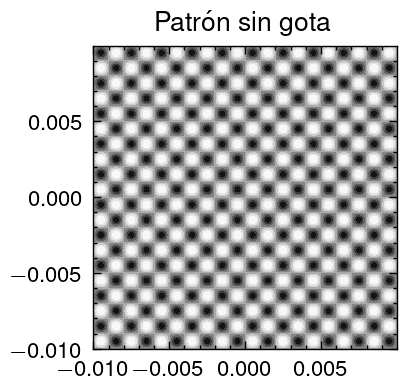

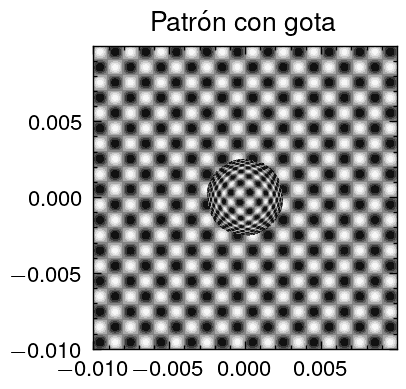

In [53]:
# TRANSFORMACIÓN Mpp a M (EVALÚO PATRÓN EN M PERO PLOTTEO/"VEO" EN Mpp)
def mppTOm(X, Y, H, hp, height_map_gradient, alpha):
    R = np.sqrt(X**2 + Y**2)
    hstar = (1/(alpha*hp) - 1/H)**(-1)
    i = R/H

    O_Mpp = np.array([X,Y])
    Mp_Mpp = -height_map_gradient*hstar
    O_Mp = O_Mpp - Mp_Mpp

    e_r = O_Mp/np.sqrt(O_Mp[0]**2 + O_Mp[1]**2)
    O_M = O_Mp - alpha*hp*i*e_r

    return O_M

def checkerboard_pattern(x, y, square_size):
    pattern = 1 + np.sin(np.pi*y/square_size)*np.sin(np.pi*x/square_size)
    return pattern


i_ref = checkerboard_pattern(X,Y, square_size=square_size)
plt.title("Patrón sin gota")
plt.contourf(X, Y, i_ref, cmap="Greys_r")
plt.gca().set_aspect("equal")
plt.show()

plt.title("Patrón con gota")
i_def = checkerboard_pattern(*mppTOm(X, Y, H, hp, height_map_gradient, alpha), square_size=square_size)
plt.contourf(X, Y, i_def, cmap="Greys")
plt.gca().set_aspect("equal");

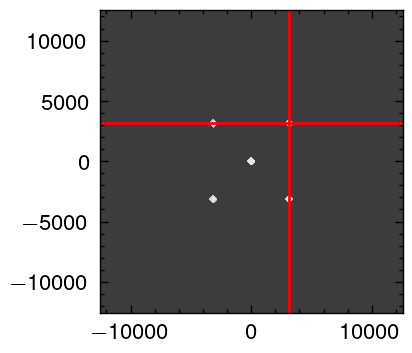

In [51]:
# TRANSFORMADAS DE FOURIER
from scipy.fft import fft2, ifft2, ifftshift, fftshift, fftfreq, fft
from pyfcd.find_peaks import find_peaks

fft_ref = fftshift(fft2(i_ref))
fft_def = fftshift(fft2(i_def))

kx = fftshift(fftfreq(x.shape[-1], resolucion)*2*np.pi)
ky = fftshift(fftfreq(y.shape[-1], resolucion)*2*np.pi)
Kx, Ky = np.meshgrid(kx, ky)

plt.contourf(Kx, Ky, np.abs(fft_ref)+1, norm=LogNorm(), cmap= "Greys_r")
plt.axhline(np.pi/square_size, color = "red")
plt.axvline(np.pi/square_size, color = "red")
plt.xlim(-4*np.pi/square_size, 4*np.pi/square_size)
plt.ylim(-4*np.pi/square_size, 4*np.pi/square_size)
plt.gca().set_aspect("equal")
plt.show()